# 轨道共振模拟（PCR3BP模型）
Orbital Resonance Simulator (PCR3BP Model)

张有闻 524432910009

2025.1.13

（上海交通大学课程PHY1621-01大作业，2024秋季学期）

## 1. 简介

轨道共振（Orbital Resonance/Mean Motion Resonance) 是指卫星、 行星等两个或多个天体的轨道频率之间存在简单的整数倍关系, 并且是互素的。


PCR3BP（Planar Restricted Circular Three-Body Problem）是研究无限小质量体在两个以圆轨道相互绕行的有限质量体引力场下的运动, 小天体的运动被限制在大天体的轨道平面内。（这里介于复杂度不考虑潮汐力的影响，尽管潮汐力也是轨道共振的重要机制之一）

（关于这方面的视觉和听觉演示，您可以参考：SYSTEMSOUNDS制作的木星卫星轨道共振可听化 www.system-sounds.com/jupiters-moons/ ；Robert J. Vanderbei教授团队制作的精确可视化 https://vanderbei.princeton.edu/WebGL/PlanetResonances.html ）


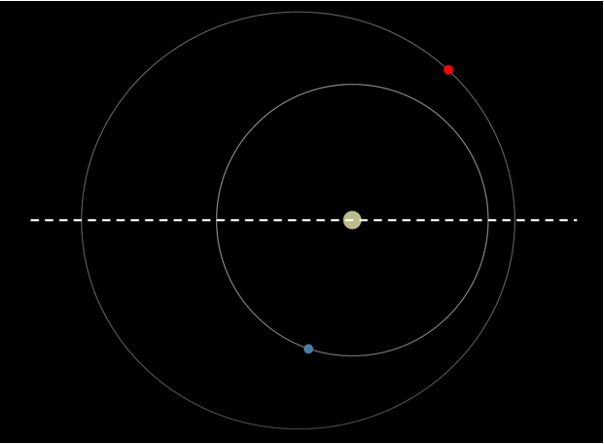 



## 2. 建模

假设中心天体<font color="yellow">Body1</font>、第二天体<font color="blue">Body2</font>、小天体<font color="orange">Body3</font>质量分别为m1、m2、m3，且m3<<m2<m1。坐标系xOy平面和三个天体轨道平面重合，原点取在Body1初始位置处。Body2绕Body1做圆周运动，Body3绕Body1做椭圆轨道运动。三个天体的位置、速度、加速度分别为ri、vi、ai（i=1,2,3)，均为三维矢量。


### 初始条件：


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 设置常量
G = 6.67430e-11  # 万有引力常数, m^3 kg^-1 s^-2

# 设置参数
m1 = 1e12  # 天体1的质量, kg
r1 = np.array([0.0, 0.0, 0.0])  # 天体1的初始位置, m
v1 = np.array([0.0, 0.0, 0.0])  # 天体1的初始速度, m/s
m2 = 1e7  # 天体2的质量, kg
r2 = np.array([-1, 0, 0.0])  # 天体2的初始位置, m
v2 = np.array([0, 8.17188, 0.0])  # 天体2的初始速度, m/s
m3 = 1  # 天体3的质量, kg
r3 = np.array([2.91, 0.0, 0.0])  # 天体3的初始位置, m
v3 = np.array([0.0, -3.71079, 0.0])  # 天体3的初始速度, m/s

通过有效势能公式和开普勒第三定律可以得到天体的公转周期$T_i$：$$E_i = \frac{1}{2} m_i v_i^2 - \frac{G m_1 m_i}{r_{1i}}$$ $$E_i = -\frac{G m_1 m_i}{2a_i}$$ $$T_i = 2\pi \sqrt{\frac{a_i^3}{G m_1}}$$ (其中 $a_i$是Bodyi轨道的半长轴，$r_{1i}$是Bodyi到Body1的距离的绝对值，i=2,3）

以上初始条件中 $$T_1:T_2 \approx 1:3 $$

于是，这三个天体的运动可以通过万有引力定律和牛顿第二定律模拟。对于Bodyi，它的加速度是：$$\ddot{\mathbf{r}}_i = G \sum_{j \neq i} \frac{m_j (\mathbf{r}_j - \mathbf{r}_i)}{\|\mathbf{r}_j - \mathbf{r}_i\|^3}$$

在t+1时刻的$v_i$、$r_i$可以用t时刻的$v_i$、$r_i$表示：

$$v_{i}^{(k+1)} = v_{i}^{(k)} + dt a_{i}^{(k)} + O(dt^2)$$ $$r_{i}^{(k+1)} = r_{i}^{(k)} + dt v_{i}^{(k)} + O(dt^2)$$

## 3. 算法

（本文完整的算法将附在最后）

先设置时间步长dt、总模拟时间T（建议设置T在[100，1000]内）

In [2]:
dt = 0.001  # 时间步长, s
T = 100  # 总模拟时间, s
num_steps = int(T / dt)  # 总步数

创建描述三个天体位置的表单和三个描述天体相对位置的表单

In [3]:
positions_1 = np.zeros((num_steps, 3))
positions_2 = np.zeros((num_steps, 3))
positions_3 = np.zeros((num_steps, 3))
distances_12 = np.zeros(num_steps)  # Body2到Body1的距离
distances_23 = np.zeros(num_steps)  # Body3到Body2的距离
distances_31 = np.zeros(num_steps)  # Body3到Body1的距离
#初始位置
positions_1[0] = r1
positions_2[0] = r2
positions_3[0] = r3

利用万有引力定律和牛顿第二定律计算dt时间后的位置和速度（r1i_norm 表示距离的绝对值）

（如果你把总模拟时间T设置得很大的话，这一步需要一点时间运行）

In [4]:
for i in range(1, num_steps):
    # 计算距离和加速度
    r12 = r2 - r1
    r12_norm = np.linalg.norm(r12)
    r23 = r3 - r2
    r23_norm = np.linalg.norm(r23)
    r31 = r1 - r3
    r31_norm = np.linalg.norm(r31)
    
    a1 = G * m2 * r12 / r12_norm**3 - G * m3 * r31 / r31_norm**3
    a2 = -G * m1 * r12 / r12_norm**3 + G * m3 * r23 / r23_norm**3
    a3 = G * m1 * r31 / r31_norm**3 - G * m2 * r23 / r23_norm**3
    
    # 更新速度和位置
    v1 += a1 * dt
    r1 += v1 * dt
    v2 += a2 * dt
    r2 += v2 * dt
    v3 += a3 * dt
    r3 += v3 * dt
    
    # 存储位置和距离
    positions_1[i] = r1
    positions_2[i] = r2
    positions_3[i] = r3
    distances_12[i] = r12_norm
    distances_23[i] = r23_norm
    distances_31[i] = r31_norm

### 3.1 轨道图

绘制轨道的模拟图

(m2,r2,v2)= 10000000.0 [-0.85314092 -0.51766988  0.        ] [-4.28037221  6.94030467  0.        ] (m3,r3,v3)= 1 [-0.35625622 -1.55488928  0.        ] [-6.03515008  3.82710228  0.        ]


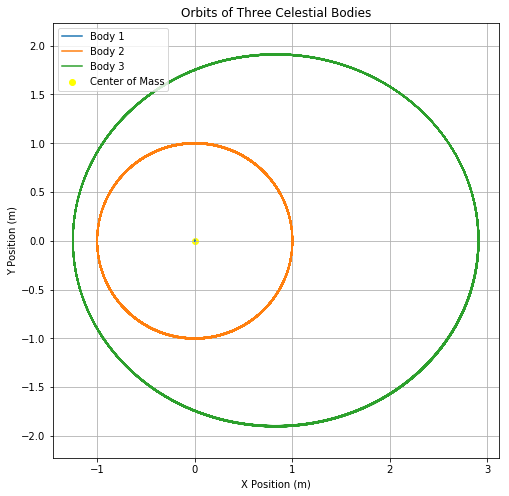

In [5]:
print("(m2,r2,v2)=", m2, r2, v2, "(m3,r3,v3)=", m3, r3, v3) 
# 绘制轨道图
plt.figure(figsize=(8, 8))
plt.plot(positions_1[:, 0], positions_1[:, 1], label='Body 1')
plt.plot(positions_2[:, 0], positions_2[:, 1], label='Body 2')
plt.plot(positions_3[:, 0], positions_3[:, 1], label='Body 3')
plt.scatter([0], [0], color='yellow', label='Center of Mass')  # 标记质心位置
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Orbits of Three Celestial Bodies')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

因为中心天体Body1的位移可以忽略，故我们可以把Body1固定在原点，画一张其余两个天体相对其的运行轨道图

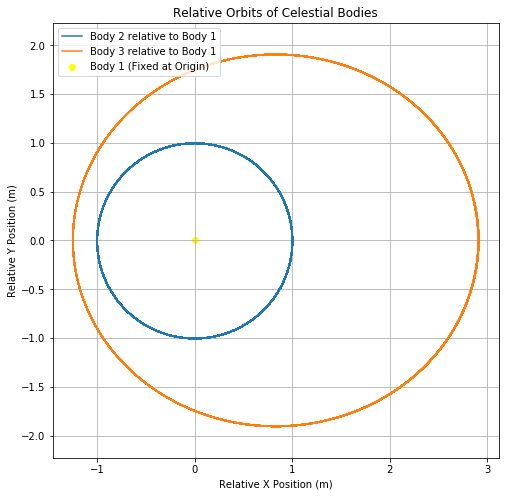

In [6]:
# 绘制相对轨道
plt.figure(figsize=(8, 8))
plt.plot(positions_2[:, 0] - positions_1[:, 0], positions_2[:, 1] - positions_1[:, 1], label='Body 2 relative to Body 1')
plt.plot(positions_3[:, 0] - positions_1[:, 0], positions_3[:, 1] - positions_1[:, 1], label='Body 3 relative to Body 1')
plt.scatter([0], [0], color='yellow', label='Body 1 (Fixed at Origin)')  # 标记质心位置
plt.xlabel('Relative X Position (m)')
plt.ylabel('Relative Y Position (m)')
plt.title('Relative Orbits of Celestial Bodies')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

我们还可以画出轨道半径的实时变化：

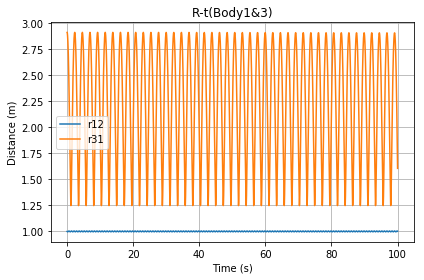

In [7]:
# Body2到Body1的距离随时间的变化
#plt.subplot(1, 2, 1)
plt.plot(np.linspace(dt, T, num_steps - 1), distances_12[1:], label='r12')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.title('R-t(Body1&2)')
plt.legend()
plt.grid(True)

# Body3到Body1的距离
#plt.subplot(1, 2, 2)
plt.plot(np.linspace(dt, T, num_steps - 1), distances_31[1:], label='r31')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.title('R-t(Body1&3)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 3.2 周期-时间图

已知某一点的速度和相对位置，可以通过有效势能公式和开普勒第三定律可以得到天体的公转周期$T_i$（这一步运行可能需要一点时间）

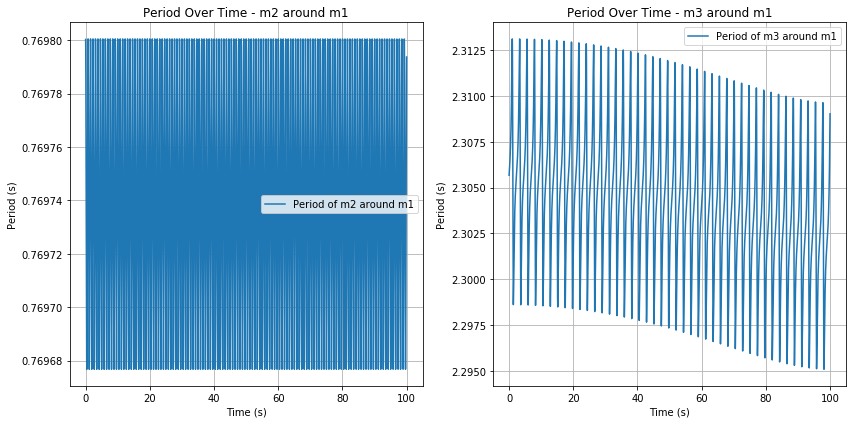

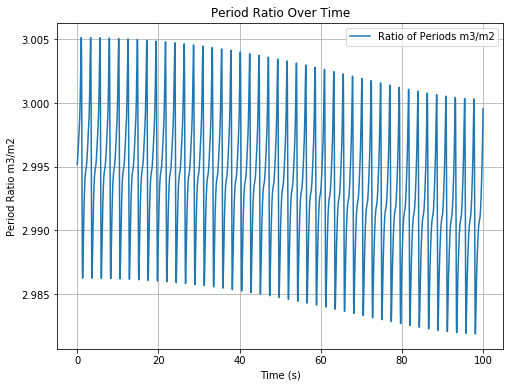

In [8]:
periods_12 = np.zeros(num_steps)  # Body2绕Body1的周期
periods_31 = np.zeros(num_steps)  # Body3绕Body1的周期
ratios = np.zeros(num_steps)  # Body2绕Body1的周期和Body3绕Body1的周期的比值
r1 = np.array([0.0, 0.0, 0.0])  
v1 = np.array([0.0, 0.0, 0.0])  
r2 = np.array([-1, 0, 0.0])  
v2 = np.array([0, 8.17188, 0.0])  
r3 = np.array([2.91, 0.0, 0.0])  
v3 = np.array([0.0, -3.71079, 0.0])  
for i in range(1, num_steps):
    r12 = r2 - r1
    r12_norm = np.linalg.norm(r12)
    r23 = r3 - r2
    r23_norm = np.linalg.norm(r23)
    r31 = r1 - r3
    r31_norm = np.linalg.norm(r31)
    a1 = G * m2 * r12 / r12_norm**3 - G * m3 * r31 / r31_norm**3
    a2 = -G * m1 * r12 / r12_norm**3 + G * m3 * r23 / r23_norm**3
    a3 = G * m1 * r31 / r31_norm**3 - G * m2 * r23 / r23_norm**3
    v1 += a1 * dt
    r1 += v1 * dt
    v2 += a2 * dt
    r2 += v2 * dt
    v3 += a3 * dt
    r3 += v3 * dt
    
    # 计算周期
    a_12 = 1 / (2 / r12_norm - np.linalg.norm(v2)**2 / (G * m1))
    a_31 = 1 / (2 / r31_norm - np.linalg.norm(v3)**2 / (G * m1))
    periods_12[i] = 2 * np.pi * np.sqrt(a_12**3 / (G * m1))
    periods_31[i] = 2 * np.pi * np.sqrt(a_31**3 / (G * m1))
    
    # 计算周期比值
    ratios[i] = periods_31[i] / periods_12[i]
    
# 绘制周期-时间图
plt.figure(figsize=(12, 6))

# Body2绕Body1的周期
plt.subplot(1, 2, 1)
plt.plot(np.linspace(dt, T, num_steps - 1), periods_12[1:], label='Period of m2 around m1')
plt.xlabel('Time (s)')
plt.ylabel('Period (s)')
plt.title('Period Over Time - m2 around m1')
plt.legend()
plt.grid(True)

# Body3绕Body1的周期
plt.subplot(1, 2, 2)
plt.plot(np.linspace(dt, T, num_steps - 1), periods_31[1:], label='Period of m3 around m1')
plt.xlabel('Time (s)')
plt.ylabel('Period (s)')
plt.title('Period Over Time - m3 around m1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 绘制比值-时间图
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(dt, T, num_steps - 1), ratios[1:], label='Ratio of Periods m3/m2')
plt.xlabel('Time (s)')
plt.ylabel('Period Ratio m3/m2')
plt.title('Period Ratio Over Time')
plt.legend()
plt.grid(True)
plt.show()

当把T设置在1000时，我们可以得到这张图：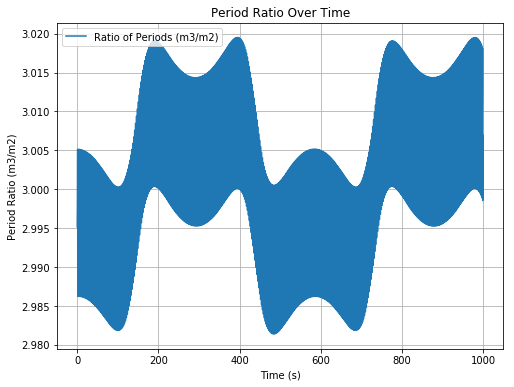

## 2. 轨道共振的机制 Conjunction

我们称Body2和Body3在它们的经度相同时（即三个天体共线时）为Conjunction（合相）。此时它们彼此最接近，因此引力影响也最强。

#### 径向力的影响

每次两个天体发生Conjunction时，Body3会受到来自Body2的径向冲击力，这会使Body3向内移动，从而使Body3轨道的半长轴减小，偏心率减小。于是，Body3的轨道周期变小。由于m3<<m2，Body3不可能一直维持在共振轨道上。我们已经从前面的周期-时间图中验证了这个结论。

#### 切向力的影响

如果Conjunction发生在外轨道的远地点或近地点，则所受的切向力在Conjunction前后是对称的。因此，Body3的角动量在合相后不会发生变化。但是如果当Conjunction不发生在远地点时，假设它发生在远地点之后，如图所示。Body3在Conjunction后所受的切向力大于Conjunction前的切向力。同时，物体之间的相对角速度在Conjunction后变小。因此，Body3在Conjunction后所受Body2的干扰力作用时间比Conjunction前长。因此，Body3会获得角动量，从而使轨道半径变大，轨道周期在Conjunction后变长。接下来，由于Body3的平均运动变慢，Body2赶上Body3花费的时间就更少。这意味着Conjunction将发生得更早，并且接近远地点。通过对发生在其他位置的Conjunction进行类似分析，可以清楚地看出，所有的Conjunction都趋向于在Body2对Body3的影响下移动到远地点附近。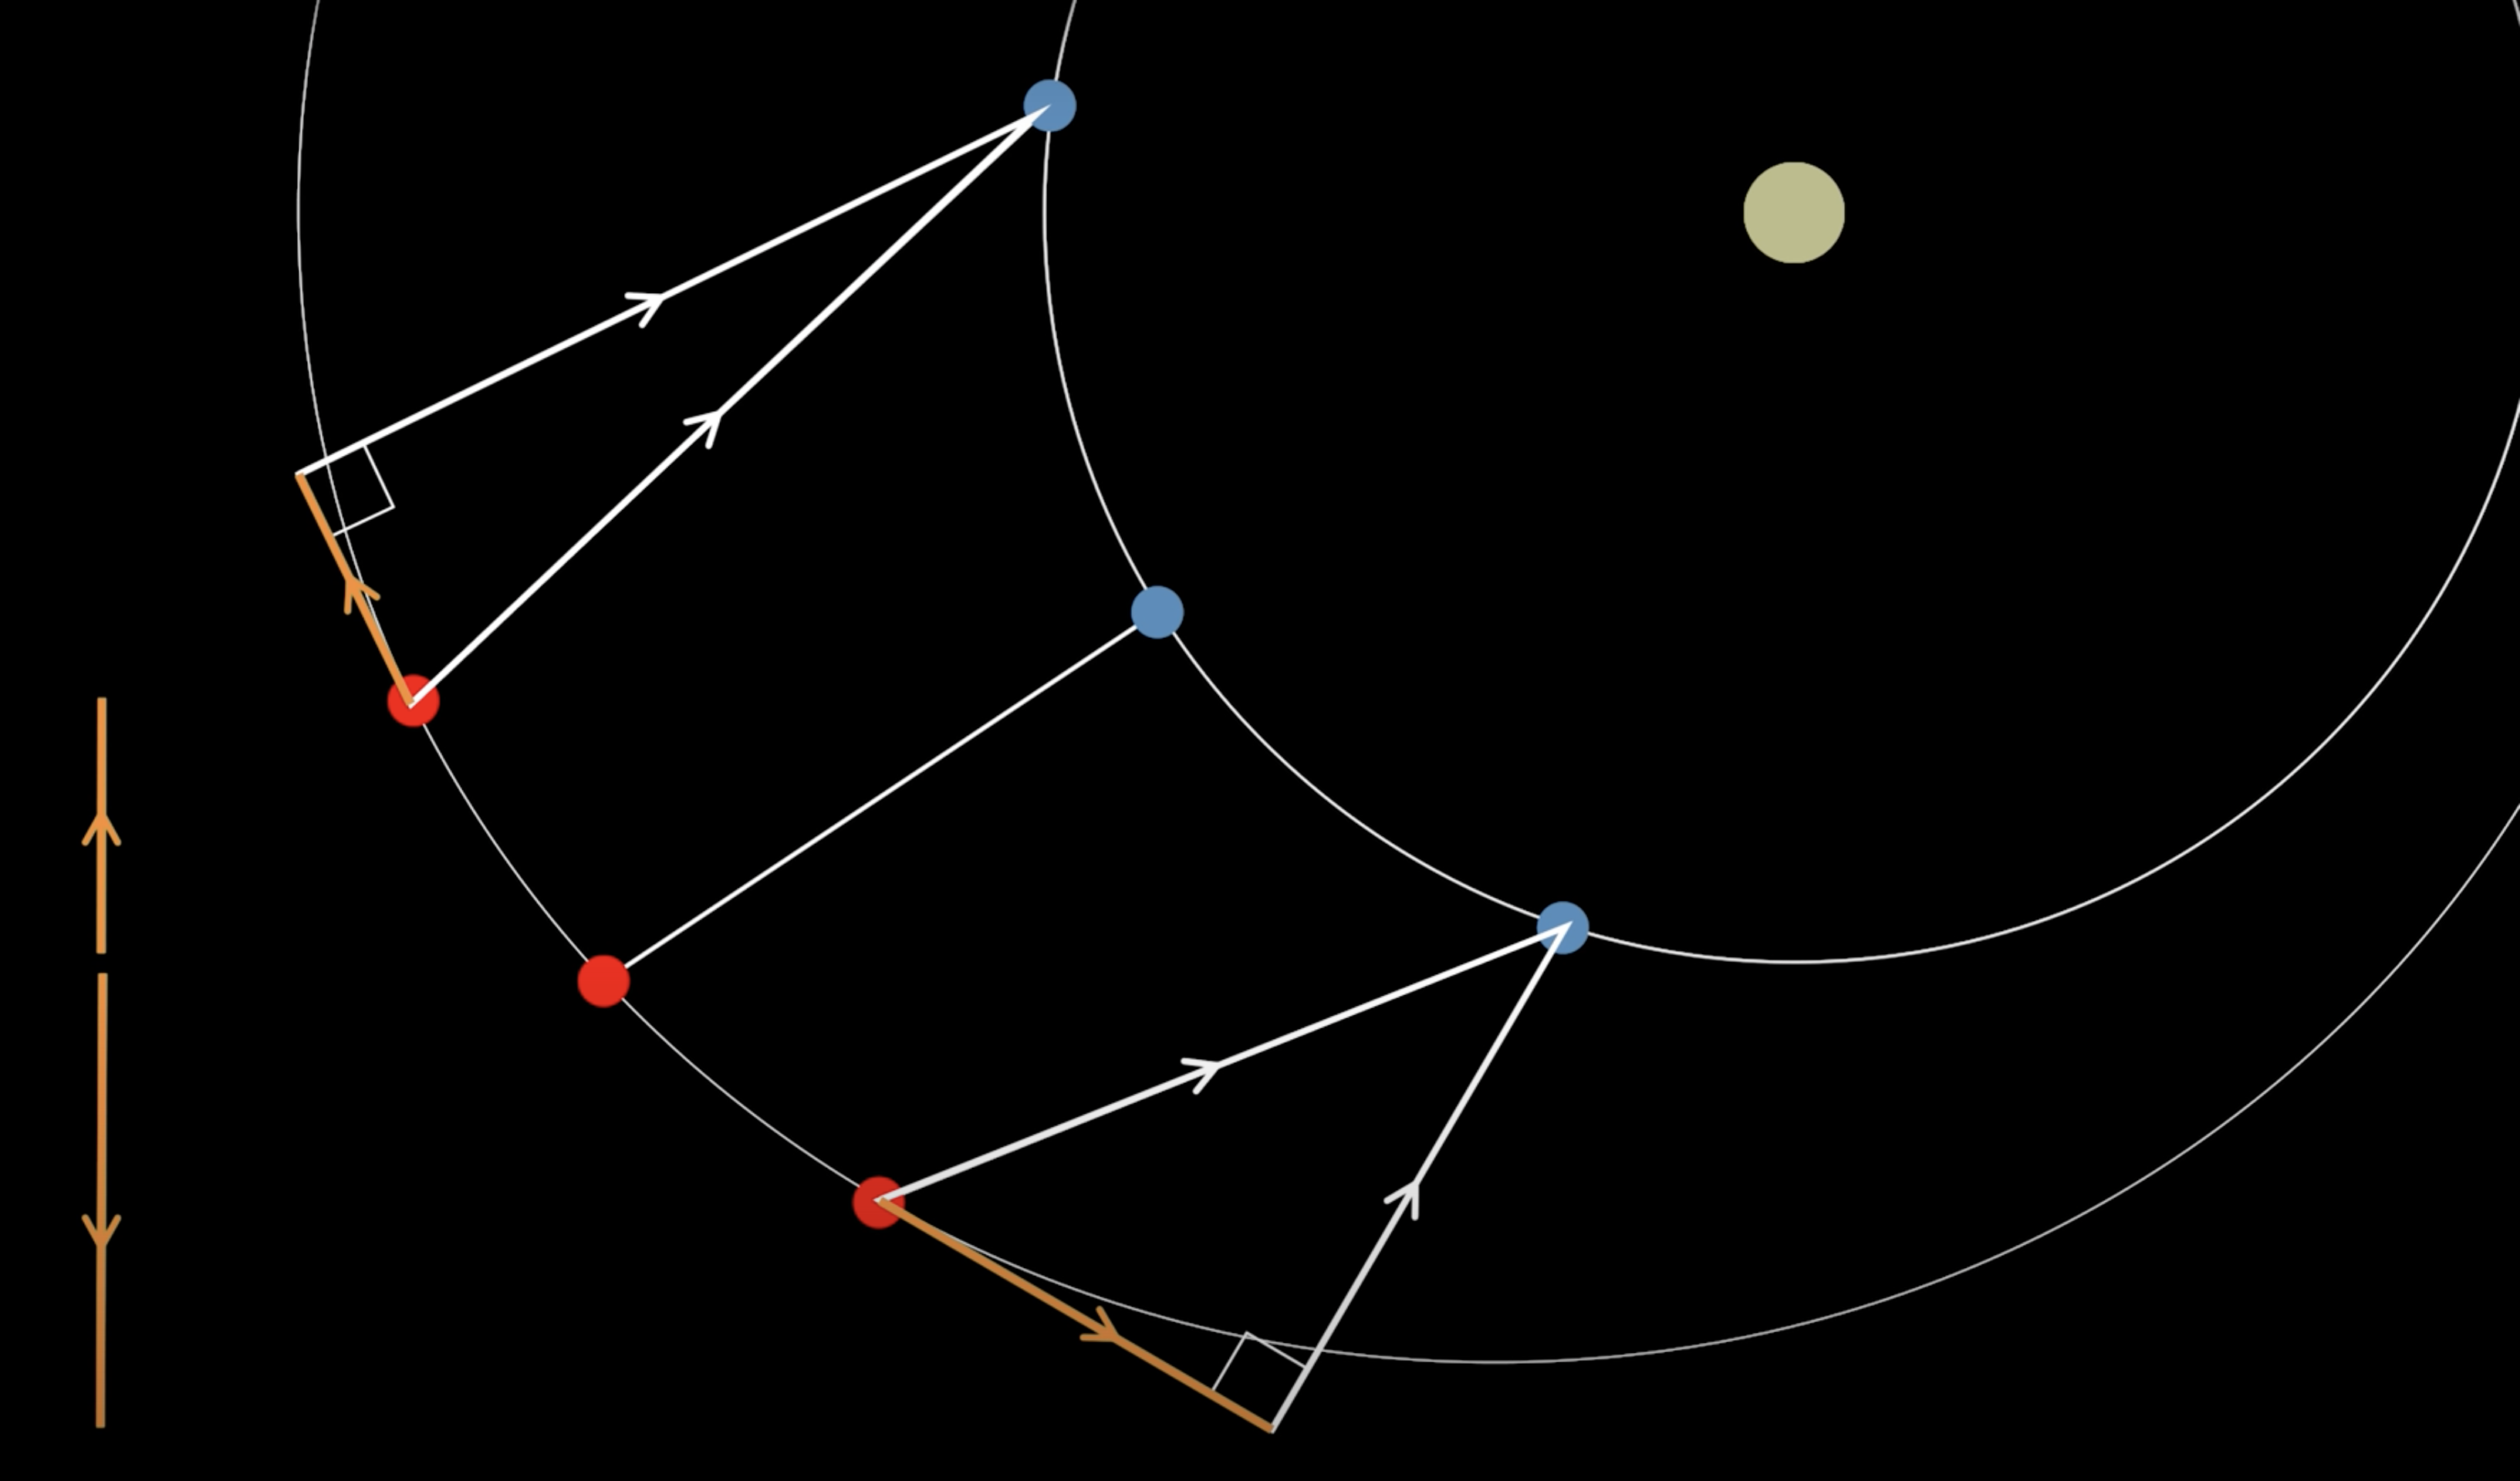

Conjunction发生时，将Body2、3用线段连起来（运行这一步需要一点时间）

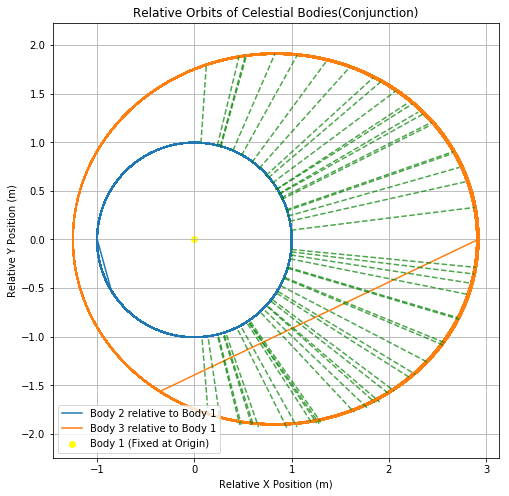

In [9]:
T = 500  # 总模拟时间, s
num_steps = int(T / dt)  # 总步数

positions_1 = np.zeros((num_steps, 3))
positions_2 = np.zeros((num_steps, 3))
positions_3 = np.zeros((num_steps, 3))
distances_12 = np.zeros(num_steps) 
distances_23 = np.zeros(num_steps) 
distances_31 = np.zeros(num_steps) 
#初始位置
positions_1[0] = r1
positions_2[0] = r2
positions_3[0] = r3
collinear_points = []  # 存储Conjunction时的位置
r1 = np.array([0.0, 0.0, 0.0])  
v1 = np.array([0.0, 0.0, 0.0])  
r2 = np.array([-1, 0, 0.0])  
v2 = np.array([0, 8.17188, 0.0])  
r3 = np.array([2.91, 0.0, 0.0])  
v3 = np.array([0.0, -3.71079, 0.0])  
for i in range(1, num_steps):
    r12 = r2 - r1
    r12_norm = np.linalg.norm(r12)
    r23 = r3 - r2
    r23_norm = np.linalg.norm(r23)
    r31 = r1 - r3
    r31_norm = np.linalg.norm(r31)
    a1 = G * m2 * r12 / r12_norm**3 - G * m3 * r31 / r31_norm**3
    a2 = -G * m1 * r12 / r12_norm**3 + G * m3 * r23 / r23_norm**3
    a3 = G * m1 * r31 / r31_norm**3 - G * m2 * r23 / r23_norm**3
    v1 += a1 * dt
    r1 += v1 * dt
    v2 += a2 * dt
    r2 += v2 * dt
    v3 += a3 * dt
    r3 += v3 * dt
    positions_1[i] = r1
    positions_2[i] = r2
    positions_3[i] = r3
    distances_12[i] = r12_norm
    distances_23[i] = r23_norm
    distances_31[i] = r31_norm

for i in range(2, num_steps - 2):
    # 检查Body2和Body3是否都位于y轴右侧
    if positions_2[i, 0] > 0 and positions_3[i, 0] > 0:
    # 检测Body1、2、3是否共线
        r12 = positions_2[i] - positions_1[i]
        r13 = positions_3[i] - positions_1[i]
        cross_product = np.cross(r12, r13)
        if np.linalg.norm(cross_product) < 1e-3:  # 使用一个小的阈值来判断是否共线
            collinear_points.append((positions_2[i], positions_3[i]))
            
#print(collinear_points) #可用于检验是否有错误
            
# 在相对轨道图上添加Conjunction时Body2、3的连线
plt.figure(figsize=(8, 8))
plt.plot(positions_2[:, 0] - positions_1[:, 0], positions_2[:, 1] - positions_1[:, 1], label='Body 2 relative to Body 1')
plt.plot(positions_3[:, 0] - positions_1[:, 0], positions_3[:, 1] - positions_1[:, 1], label='Body 3 relative to Body 1')
plt.scatter([0], [0], color='yellow', label='Body 1 (Fixed at Origin)')  
# 绘制Body1、2、3三点共线时的位置连线
for r2, r3 in collinear_points:
    # 计算相对位置
    r2_rel = r2 - r1
    r3_rel = r3 - r1
    # 绘制绿色虚线
    plt.plot([r2_rel[0], r3_rel[0]], [r2_rel[1], r3_rel[1]], 'g--', alpha=0.7)

plt.xlabel('Relative X Position (m)')
plt.ylabel('Relative Y Position (m)')
plt.title('Relative Orbits of Celestial Bodies(Conjunction)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

调试一下总模拟时间T，你会得到下面这样的结果：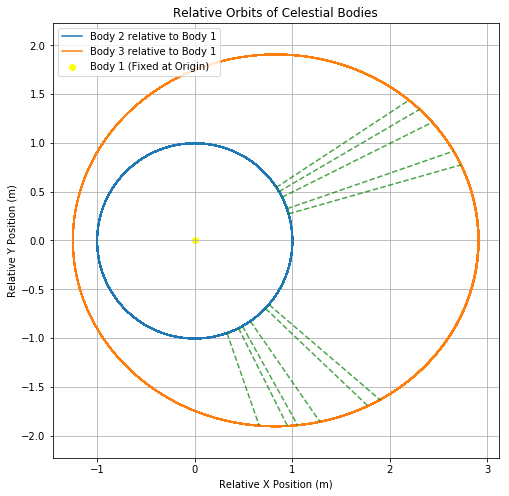 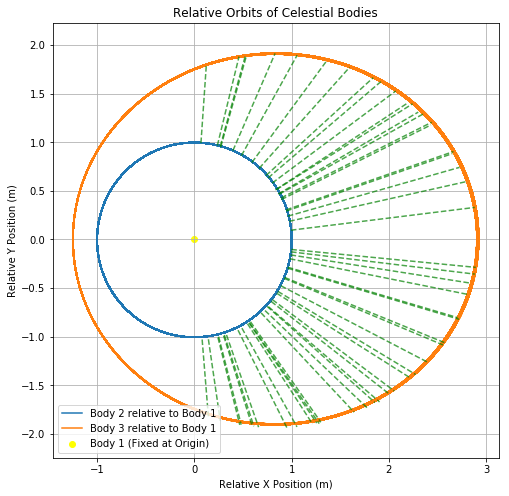  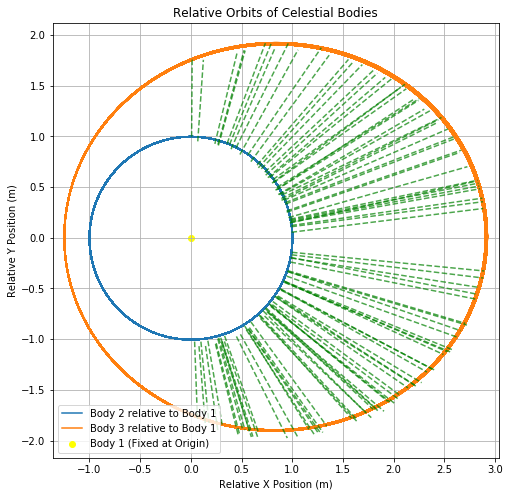从上到下分别是T=100、500、1000的结果。可以发现当T较小时，T越大，Conjunction会趋向于发生在远日点；而当T较大时，并没有这种趋势。

但是这并不妨碍轨道共振所带来的稳定性。

## 3. 轨道共振的稳定性

取T=3000，从上到下$$T_1:T_2 \approx 1:2、3:7、2:5、1:3、1:5 $$ 可以发现周期比为1:2和1:5的共振轨道相对其余的更加不稳定。

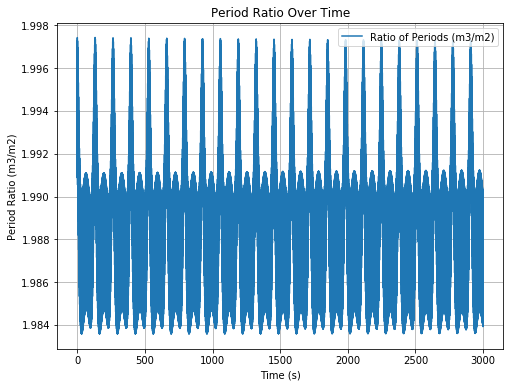 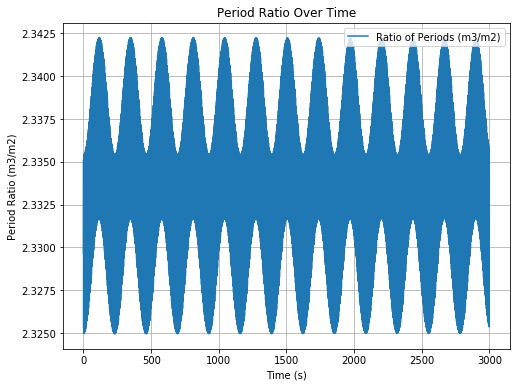 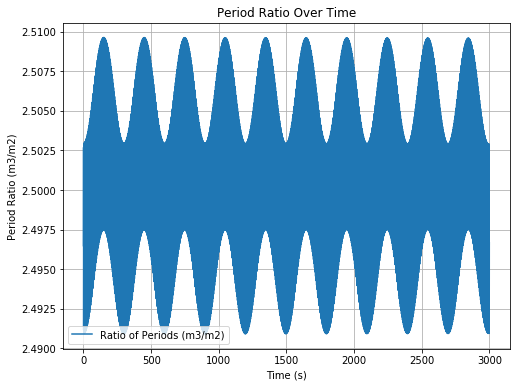 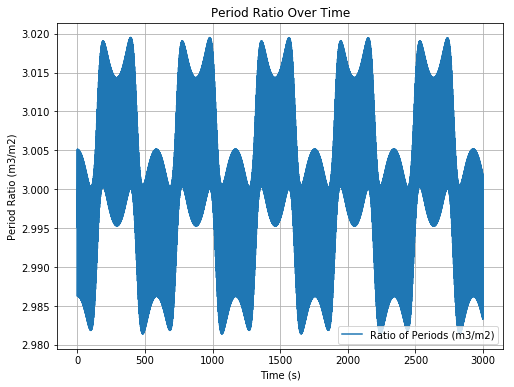  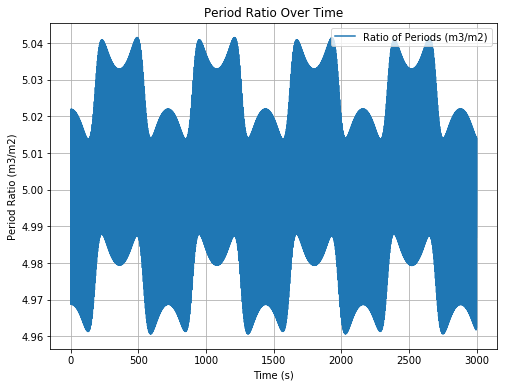

## 总结

笔者提供了一个python算法，可用于模拟PCR3BP模型的轨道共振。笔者对Conjunction和轨道稳定性进行了分析，得出导致共振轨道不稳定的可能原因。后续研究可以将其推广到三维运动，或者加入潮汐力的影响，会使得模拟更加符合实际。

## 参考文献

[1] C. D. Murray and S. F. Dermott, Solar System Dynamics (Cambridge, 1999).

[2] S. J. Peale, "Orbital Resonances in the Solar System," Ann. Rev. Astro. Astrophys. 14, 215 (1976).

图片来源：www.youtube.com/watch?v=Qyn64b4LNJ0

本文在AI的协助下完成（Kimi）

## 附录

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 设置常量
G = 6.67430e-11  # 万有引力常数, m^3 kg^-1 s^-2
dt = 0.001  # 时间步长, s
T = 100  # 总模拟时间, s
num_steps = int(T / dt)  # 总步数

# 天体参数
m1 = 1e12  # 天体1的质量, kg
r1 = np.array([0.0, 0.0, 0.0])  # 天体1的初始位置, m
v1 = np.array([0.0, 0.0, 0.0])  # 天体1的初始速度, m/s
m2 = 1e7  # 天体2的质量, kg
r2 = np.array([-1, 0, 0.0])  # 天体2的初始位置, m
v2 = np.array([0, 8.17188, 0.0])  # 天体2的初始速度, m/s
m3 = 1  # 天体3的质量, kg
r3 = np.array([2.91, 0.0, 0.0])  # 天体3的初始位置, m
v3 = np.array([0.0, -3.71079, 0.0])  # 天体3的初始速度, m/s

print("(m2,r2,v2)=", m2, r2, v2, "(m3,r3,v3)=", m3, r3, v3)

# 存储位置和距离数据
positions_1 = np.zeros((num_steps, 3))
positions_2 = np.zeros((num_steps, 3))
positions_3 = np.zeros((num_steps, 3))
distances_12 = np.zeros(num_steps)  # Body2到Body1的距离
distances_23 = np.zeros(num_steps)  # Body3到Body2的距离
distances_31 = np.zeros(num_steps)  # Body3到Body1的距离
periods_12 = np.zeros(num_steps)  # Body2绕Body1的周期
periods_31 = np.zeros(num_steps)  # Body3绕Body1的周期
ratios = np.zeros(num_steps)  # Body2绕Body1的周期和Body3绕Body1的周期的比值
collinear_points = []  # 存储Body1、2、3三点共线时的位置

# 初始位置
positions_1[0] = r1
positions_2[0] = r2
positions_3[0] = r3

# 模拟循环
for i in range(1, num_steps):
    # 计算距离和加速度
    r12 = r2 - r1
    r12_norm = np.linalg.norm(r12)
    r23 = r3 - r2
    r23_norm = np.linalg.norm(r23)
    r31 = r1 - r3
    r31_norm = np.linalg.norm(r31)
    
    a1 = G * m2 * r12 / r12_norm**3 - G * m3 * r31 / r31_norm**3
    a2 = -G * m1 * r12 / r12_norm**3 + G * m3 * r23 / r23_norm**3
    a3 = G * m1 * r31 / r31_norm**3 - G * m2 * r23 / r23_norm**3
    
    # 更新速度和位置
    v1 += a1 * dt
    r1 += v1 * dt
    v2 += a2 * dt
    r2 += v2 * dt
    v3 += a3 * dt
    r3 += v3 * dt
    
    # 存储位置和距离
    positions_1[i] = r1
    positions_2[i] = r2
    positions_3[i] = r3
    distances_12[i] = r12_norm
    distances_23[i] = r23_norm
    distances_31[i] = r31_norm
    
    # 计算周期
    a_12 = 1 / (2 / r12_norm - np.linalg.norm(v2)**2 / (G * m1))
    a_31 = 1 / (2 / r31_norm - np.linalg.norm(v3)**2 / (G * m1))
    periods_12[i] = 2 * np.pi * np.sqrt(a_12**3 / (G * m1))
    periods_31[i] = 2 * np.pi * np.sqrt(a_31**3 / (G * m1))
    
    # 计算周期比值
    ratios[i] = periods_31[i] / periods_12[i]
    
    
for i in range(2, num_steps - 2):
    # 检查Body2和Body3是否都位于y轴右侧
    if positions_2[i, 0] > 0 and positions_3[i, 0] > 0:
    # 检测Body1、2、3是否共线
        r12 = positions_2[i] - positions_1[i]
        r13 = positions_3[i] - positions_1[i]
        cross_product = np.cross(r12, r13)
        if np.linalg.norm(cross_product) < 1e-3:  # 使用一个小的阈值来判断是否共线
            collinear_points.append((positions_2[i], positions_3[i]))
    

# 绘制轨道
plt.figure(figsize=(8, 8))
plt.plot(positions_1[:, 0], positions_1[:, 1], label='Body 1')
plt.plot(positions_2[:, 0], positions_2[:, 1], label='Body 2')
plt.plot(positions_3[:, 0], positions_3[:, 1], label='Body 3')
plt.scatter([0], [0], color='yellow', label='Center of Mass')  # 标记质心位置
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Orbits of Three Celestial Bodies')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# 绘制距离-时间图
plt.figure(figsize=(12, 6))

# Body2到Body1的距离
plt.subplot(1, 2, 1)
plt.plot(np.linspace(dt, T, num_steps - 1), distances_12[1:], label='Distance between m1 and m2')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.title('Distance Over Time - m1 and m2')
plt.legend()
plt.grid(True)

# Body3到Body1的距离
plt.subplot(1, 2, 2)
plt.plot(np.linspace(dt, T, num_steps - 1), distances_31[1:], label='Distance between m1 and m3')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.title('Distance Over Time - m1 and m3')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 绘制周期-时间图
plt.figure(figsize=(12, 6))

# Body2绕Body1的周期
plt.subplot(1, 2, 1)
plt.plot(np.linspace(dt, T, num_steps - 1), periods_12[1:], label='Period of m2 around m1')
plt.xlabel('Time (s)')
plt.ylabel('Period (s)')
plt.title('Period Over Time - m2 around m1')
plt.legend()
plt.grid(True)

# Body3绕Body1的周期
plt.subplot(1, 2, 2)
plt.plot(np.linspace(dt, T, num_steps - 1), periods_31[1:], label='Period of m3 around m1')
plt.xlabel('Time (s)')
plt.ylabel('Period (s)')
plt.title('Period Over Time - m3 around m1')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 绘制比值-时间图
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(dt, T, num_steps - 1), ratios[1:], label='Ratio of Periods (m3/m2)')
plt.xlabel('Time (s)')
plt.ylabel('Period Ratio (m3/m2)')
plt.title('Period Ratio Over Time')
plt.legend()
plt.grid(True)
plt.show()

#print(collinear_points)
# 绘制相对轨道
plt.figure(figsize=(8, 8))
plt.plot(positions_2[:, 0] - positions_1[:, 0], positions_2[:, 1] - positions_1[:, 1], label='Body 2 relative to Body 1')
plt.plot(positions_3[:, 0] - positions_1[:, 0], positions_3[:, 1] - positions_1[:, 1], label='Body 3 relative to Body 1')
plt.scatter([0], [0], color='yellow', label='Body 1 (Fixed at Origin)')  # 标记质心位置
# 绘制Body1、2、3三点共线时的位置连线
for r2, r3 in collinear_points:
    # 计算相对位置
    r2_rel = r2 - r1
    r3_rel = r3 - r1
    # 绘制蓝色虚线
    plt.plot([r2_rel[0], r3_rel[0]], [r2_rel[1], r3_rel[1]], 'g--', alpha=0.7)

plt.xlabel('Relative X Position (m)')
plt.ylabel('Relative Y Position (m)')
plt.title('Relative Orbits of Celestial Bodies')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()